# Set Parameter
- Attention = Luong
- Teacher Forcing Ratio = 0.5
- Layer = 1
- Batch size = 32
- Drop out = 0.2
- Hidden unit = [2, 50]
- Distance = [0, 96]
- Epochs = 100
- N = 100
- Data = 100K
- Deduplication

# Import packages

import useful packages for experiments

In [1]:
import os
import argparse
import logging
import sys

import torch
from torch.optim.lr_scheduler import StepLR
import torchtext

sys.path.append(os.path.dirname(os.path.abspath(os.path.dirname(os.path.abspath(os.path.dirname('__file__'))))))

from trainer.supervised_trainer_without_eval import SupervisedTrainer_without_eval
from models.encoderRNN import EncoderRNN
from models.decoderRNN import DecoderRNN
from models.seq2seq import Seq2seq
from loss.loss import Perplexity
from optim.optim import Optimizer
from dataset import fields
from evaluator.evaluator import Evaluator

import matplotlib.pyplot as plt

/home/hyeontae/hyeontae/venv2/lib/python3.5/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


# Log format

In [2]:
log_level = 'info'
LOG_FORMAT = '%(asctime)s %(levelname)-6s %(message)s'
logging.basicConfig(format=LOG_FORMAT, level=getattr(logging, log_level.upper()))

# Data load

In [3]:
train_path = "../../data/bracket_dedup/K100/data_train.txt"

# Prepare dataset

In [4]:
src = fields.SourceField()
tgt = fields.TargetField()
max_len = 104
def len_filter(example):
    return len(example.src) <= max_len and len(example.tgt) <= max_len
train = torchtext.data.TabularDataset(
    path=train_path, format='tsv',
    fields=[('src', src), ('tgt', tgt)],
    filter_pred=len_filter
)
src.build_vocab(train)
tgt.build_vocab(train)
input_vocab = src.vocab
output_vocab = tgt.vocab

# Prepare loss

In [5]:
weight = torch.ones(len(tgt.vocab))
pad = tgt.vocab.stoi[tgt.pad_token]
loss = Perplexity(weight, pad)
if torch.cuda.is_available():
    loss.cuda()

/home/hyeontae/hyeontae/venv2/lib/python3.5/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


# Variable definition

In [6]:
optimizer = "Adam"
hidden_sizes = list(range(2, 51, 4))
distance_list = []
bidirectional = True
print(hidden_sizes)
evaluator = Evaluator(loss=loss, batch_size=32)

[2, 6, 10, 14, 18, 22, 26, 30, 34, 38, 42, 46, 50]


In [7]:
for i in hidden_sizes:
    hidden_size = i
    print("hidden size is : %d" % hidden_size)
    seq2seq = None
    encoder = EncoderRNN(len(src.vocab), max_len, hidden_size,
                         bidirectional=bidirectional, variable_lengths=True)
    decoder = DecoderRNN(len(tgt.vocab), max_len, hidden_size * 2 if bidirectional else hidden_size,
                         dropout_p=0.2, use_attention="Luong", bidirectional=bidirectional,
                         eos_id=tgt.eos_id, sos_id=tgt.sos_id)
    seq2seq = Seq2seq(encoder, decoder)
    if torch.cuda.is_available():
        seq2seq.cuda()

    for param in seq2seq.parameters():
        param.data.uniform_(-0.08, 0.08)
    
    distances = list(range(96, -1, -2))
    print(distances)
    for distance in distances:
        log_path = "../../log/pth/bracket_dedup_K100_hidden_" + str(hidden_size) + "_model_save.pth"
        seq2seq.load_state_dict(torch.load(log_path))
        seq2seq.eval()
        dev_path = "../../data/bracket_dedup/K100/dev_distance/data_test_distance_" + str(distance) + ".txt"
        dev = torchtext.data.TabularDataset(
              path=dev_path, format='tsv',
              fields=[('src', src), ('tgt', tgt)],
              filter_pred=len_filter)
        dev_loss, character_accuracy, sentence_accuracy = evaluator.evaluate(seq2seq, dev)
        print("Distance:%d, Dev Loss:%0.4f, Character Accuracy:%0.4f, Sentence Accuracy:%0.4f\n"
                    % (distance, dev_loss, character_accuracy, sentence_accuracy))
        check_path = "../../log/check_point/bracket_dedup_hidden_size_to_distance_0.99/hidden_size_" + str(hidden_size)
        with open(check_path, 'a') as f:
            f.write("Distance:%d, Dev Loss:%0.4f, Character Accuracy:%0.4f, Sentence Accuracy:%0.4f\n"
                    % (distance, dev_loss, character_accuracy, sentence_accuracy))
            
        if character_accuracy >= 0.99:
            distance_list.append(distance)
            break
        if distance == 0:
            distance_list.append(distance)

hidden size is : 2
[96, 94, 92, 90, 88, 86, 84, 82, 80, 78, 76, 74, 72, 70, 68, 66, 64, 62, 60, 58, 56, 54, 52, 50, 48, 46, 44, 42, 40, 38, 36, 34, 32, 30, 28, 26, 24, 22, 20, 18, 16, 14, 12, 10, 8, 6, 4, 2, 0]


/home/hyeontae/hyeontae/venv2/lib/python3.5/site-packages/torch/nn/modules/rnn.py:46: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  "num_layers={}".format(dropout, num_layers))
/home/hyeontae/hyeontae/venv2/lib/python3.5/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Distance:96, Dev Loss:86.8922, Character Accuracy:0.1753, Sentence Accuracy:0.0000

Distance:94, Dev Loss:85.1757, Character Accuracy:0.1764, Sentence Accuracy:0.0000

Distance:92, Dev Loss:73.3644, Character Accuracy:0.1786, Sentence Accuracy:0.0000

Distance:90, Dev Loss:72.4848, Character Accuracy:0.1719, Sentence Accuracy:0.0000

Distance:88, Dev Loss:66.4828, Character Accuracy:0.1715, Sentence Accuracy:0.0000

Distance:86, Dev Loss:61.5668, Character Accuracy:0.1674, Sentence Accuracy:0.0000

Distance:84, Dev Loss:54.6836, Character Accuracy:0.1755, Sentence Accuracy:0.0000

Distance:82, Dev Loss:53.0508, Character Accuracy:0.1710, Sentence Accuracy:0.0000

Distance:80, Dev Loss:47.8900, Character Accuracy:0.1810, Sentence Accuracy:0.0000

Distance:78, Dev Loss:48.5419, Character Accuracy:0.1773, Sentence Accuracy:0.0000

Distance:76, Dev Loss:44.8631, Character Accuracy:0.1873, Sentence Accuracy:0.0000

Distance:74, Dev Loss:44.4303, Character Accuracy:0.1831, Sentence Accuracy:

Distance:2, Dev Loss:1.0928, Character Accuracy:0.9764, Sentence Accuracy:0.8645

Distance:0, Dev Loss:1.3725, Character Accuracy:0.9021, Sentence Accuracy:0.3182

hidden size is : 10
[96, 94, 92, 90, 88, 86, 84, 82, 80, 78, 76, 74, 72, 70, 68, 66, 64, 62, 60, 58, 56, 54, 52, 50, 48, 46, 44, 42, 40, 38, 36, 34, 32, 30, 28, 26, 24, 22, 20, 18, 16, 14, 12, 10, 8, 6, 4, 2, 0]
Distance:96, Dev Loss:1.9266, Character Accuracy:0.7258, Sentence Accuracy:0.0000

Distance:94, Dev Loss:1.9176, Character Accuracy:0.7276, Sentence Accuracy:0.0000

Distance:92, Dev Loss:1.9036, Character Accuracy:0.7291, Sentence Accuracy:0.0000

Distance:90, Dev Loss:1.8569, Character Accuracy:0.7395, Sentence Accuracy:0.0000

Distance:88, Dev Loss:1.8519, Character Accuracy:0.7394, Sentence Accuracy:0.0000

Distance:86, Dev Loss:1.8414, Character Accuracy:0.7430, Sentence Accuracy:0.0000

Distance:84, Dev Loss:1.8039, Character Accuracy:0.7481, Sentence Accuracy:0.0000

Distance:82, Dev Loss:1.7924, Character Acc

Distance:96, Dev Loss:1.5043, Character Accuracy:0.8375, Sentence Accuracy:0.0000

Distance:94, Dev Loss:1.4512, Character Accuracy:0.8510, Sentence Accuracy:0.0000

Distance:92, Dev Loss:1.4280, Character Accuracy:0.8563, Sentence Accuracy:0.0000

Distance:90, Dev Loss:1.3906, Character Accuracy:0.8666, Sentence Accuracy:0.0000

Distance:88, Dev Loss:1.3678, Character Accuracy:0.8713, Sentence Accuracy:0.0000

Distance:86, Dev Loss:1.3531, Character Accuracy:0.8786, Sentence Accuracy:0.0000

Distance:84, Dev Loss:1.3038, Character Accuracy:0.8892, Sentence Accuracy:0.0000

Distance:82, Dev Loss:1.3029, Character Accuracy:0.8911, Sentence Accuracy:0.0006

Distance:80, Dev Loss:1.2628, Character Accuracy:0.9036, Sentence Accuracy:0.0017

Distance:78, Dev Loss:1.2861, Character Accuracy:0.9029, Sentence Accuracy:0.0007

Distance:76, Dev Loss:1.2257, Character Accuracy:0.9168, Sentence Accuracy:0.0102

Distance:74, Dev Loss:1.2409, Character Accuracy:0.9164, Sentence Accuracy:0.0095

Dist

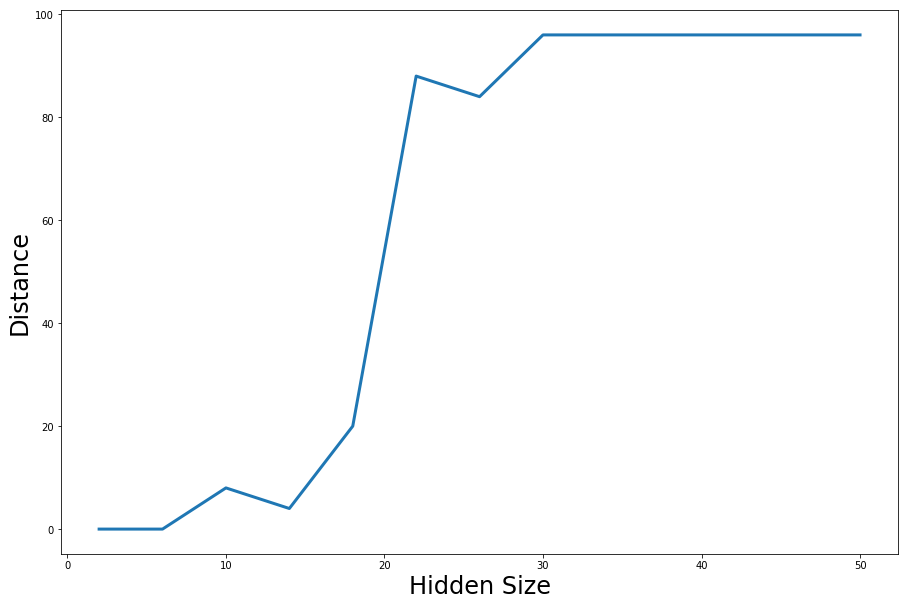

In [9]:
plt.figure(figsize=(15,10))
plt.plot(hidden_sizes, distance_list, LineWidth=3)
plt.xlabel('Hidden Size', fontsize=24)
plt.ylabel('Distance', fontsize=24)
plt.savefig('../../log/plot/bracket_dedup_hidden_size_to_distance_0.99/bracket_dedup_hidden_size_to_distance.png')

In [ ]:
print(hidden_sizes)
print(distance_list)